### References Used for this Notebook

Training model and getting predictions:
- https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-train-model.html
- https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html
- https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-test-model-batch.html

Getting Classifications from XGBoost output and optimal threshold:
- https://github.com/dmlc/xgboost/tree/master/demo/binary_classification
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Evaluation Metrics:
- https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer  
from io import StringIO

In [2]:
# Specify bucket
bucket = 'cloudcomputinggroup10data'
prefix = 'sagemaker/xgboost'

# Gets needed IAM role
role = get_execution_role()

# Get this for hyperparameter tuning job 
smclient = boto3.Session().client('sagemaker')

# Get region
region = boto3.Session().region_name  

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# Set up container with most recent version of xgboost
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

In [4]:
# Get training and validation data from S3

train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_simplified')
print(train_data)

s3://cloudcomputinggroup10data/sagemaker/xgboost/train


## Set up Sagemaker estimator object and add hyperparameters

In [5]:
# Create an instance of the sagemaker.estimator.Estimator class
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

In [6]:
# Set the hyperparameter values for the XGBoost training job by calling the set_hyperparameters method of 
# the estimator. 
# Using hyperparameters from optimal model in 'JG - XGBoost'
xgb_model.set_hyperparameters(alpha=1.140710,
                              max_depth = 10,
                              eta = 0.273211,
                              min_child_weight = 10,
                              objective = 'binary:logistic',
                              num_round = 100)

In [7]:
# Create the training channels to use for the training job. 
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

## Train model on training and validation data from S3

In [8]:
# To start model training, call the estimator's fit method
xgb_model.fit(inputs=data_channels,  logs=True)

2020-04-15 21:56:30 Starting - Starting the training job...
2020-04-15 21:56:32 Starting - Launching requested ML instances...
2020-04-15 21:57:29 Starting - Preparing the instances for training......
2020-04-15 21:58:30 Downloading - Downloading input data...
2020-04-15 21:58:58 Training - Downloading the training image...
2020-04-15 21:59:18 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:59:20] 199364x30 matrix with 5980920 entries loaded from /opt/m

Training seconds: 91
Billable seconds: 91


## Get predictions for Unlabeled Test Data

In [23]:
# The location of the test dataset
batch_input = 's3://{}/{}/test'.format(bucket, prefix)

# The location to store the results of the batch transform job
# Go into this folder and delete whatever is in there if re-running this block of code
batch_output = 's3://{}/{}/test/test_batch_results'.format(bucket, prefix)

transformer = xgb_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

Using already existing model: sagemaker-xgboost-2020-04-09-23-51-58-674


........................[2020-04-10 00:10:01 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-04-10 00:10:01 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-04-10 00:10:01 +0000] [15] [INFO] Using worker: gevent
[2020-04-10 00:10:01 +0000] [22] [INFO] Booting worker with pid: 22
[2020-04-10 00:10:01 +0000] [23] [INFO] Booting worker with pid: 23
[2020-04-10 00:10:01 +0000] [27] [INFO] Booting worker with pid: 27
[2020-04-10 00:10:01 +0000] [31] [INFO] Booting worker with pid: 31
[2020-04-10:00:10:14:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [10/Apr/2020:00:10:14 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [10/Apr/2020:00:10:14 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-04-10:00:10:14:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [10/Apr/2020:00:10:14 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [10/Ap

In [24]:
# Access 'test_data_no_label.csv.out' file with predictions
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(prefix + '/test/test_batch_results/test_data_no_label.csv.out',  'batch_results')

In [25]:
# Create list to append output values
probabilities_list = []

# Loop through and collect results for each instance
with open('batch_results') as f:
    results = f.read().splitlines() 
for j in range (0, len(results)):
    probabilities_list.append(float(results[j]))

In [26]:
# Check the length of results list is the same as the length of the training csv
len(probabilities_list)

28481

In [27]:
# Note we used xgboost with objective: "binary:logistic" which outputs probabilities, not class labels
# We can analyze the results and play with the threshold for classification

predicted_probs_df = pd.DataFrame({'probabilities':probabilities_list})
predicted_probs_df.shape

(28481, 1)

## Get Labeled Test Data for Evaluation

In [14]:
# Get this for interacting with s3 buckets
client = boto3.Session().client('s3')

# Read in test dataset with labels
csv_obj = client.get_object(Bucket=bucket, Key='sagemaker/xgboost/evaluation/test_with_label.csv')
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

test_df = pd.read_csv(StringIO(csv_string), names=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'])

test_df.shape

(28481, 31)

In [15]:
# 54 instances of actual fraud
sum(test_df['Class'])

54

## Create Precision-Recall Curve

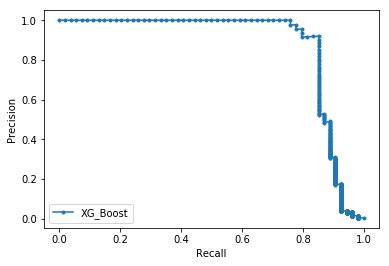

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

# Get precision, recall, and thresholds
precision, recall, thresh = precision_recall_curve(test_df['Class'], predicted_probs_df['probabilities'])

# plot the precision-recall curves
pyplot.plot(recall, precision, marker='.', label='XG_Boost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [29]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=thresh, y=recall, hovertext = thresh,
                    mode='lines',
                    name='recall'))
fig.add_trace(go.Scatter(x=thresh, y=precision, hovertext = thresh,
                    mode='lines',
                    name='precision'))
fig.update_layout(
    title='Thresholds vs. Recall & Precision',
    xaxis_title='Thresholds',
    yaxis_title='Recall and Precision')

fig.show()

In [30]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=recall, y=precision, hovertext = thresh, fill = 'tonexty',
                    mode='lines',
                    name='recall'))

fig.update_layout(
    title='Precision - Recall Curve (Hover for Threshold)',
    xaxis_title='Recall',
    yaxis_title='Precision')


fig.show()

## Get Binary Classifications From Model Based on Optimal Threshold
From the charts above, we can see that an optimal threshold might be 8.25%.  Let's see what kind of confusion matrix this will give us.

In [19]:
# Get classifications for a .0616 probability threshold
threshold = .0616
predicted_probs_df['classification'] = (predicted_probs_df['probabilities'] > threshold).astype(np.int)

## Create Confusion Matrix and Calculate Evaluation Metrics

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df['Class'], predicted_probs_df['classification'])
cm

array([[28419,     8],
       [    8,    46]])

In [21]:
tn, fp, fn, tp = cm.ravel()
print('True Negatives: ' + tn.astype(str))
print('False Positives: ' + fp.astype(str))
print('False Negatives: ' + fn.astype(str))
print('True Positives: ' + tp.astype(str))

True Negatives: 28419
False Positives: 8
False Negatives: 8
True Positives: 46


In [22]:
# Precision - proportion of transactions identified as fraud by the model that were actually fraud
XGBoost_Precision = tp / (tp + fp)

# Recall - proportion of fraud identified out of all fraudulent transactions present in the data
XGBoost_Recall = tp / (tp + fn)

# F-measure - combines precision and recall into one metric
XGBoost_F_Measure = (2 * XGBoost_Precision * XGBoost_Recall) / (XGBoost_Precision + XGBoost_Recall)

print('Precision: ' + XGBoost_Precision.astype(str))
print('Recall: ' + XGBoost_Recall.astype(str))
print('F-Score: ' + XGBoost_F_Measure.astype(str))

Precision: 0.8518518518518519
Recall: 0.8518518518518519
F-Score: 0.8518518518518519


## Write DataFrame with Classifications out to CSV - Use this to recreate Plotly visuals locally and send to HTML for Web App

In [76]:
predicted_probs_df.head()

probabilities  classification
0       0.002139               0
1       0.001060               0
2       0.000082               0
3       0.000047               0
4       0.000057               0

In [78]:
# Use this locally to make plotly vizzes in HTML
predicted_probs_df.to_csv('XGBoost_Classifications.csv', index=False)

In [79]:
# Use this locally to make plotly vizzes in HTML
test_df.to_csv('test_data_use_for_plotly.csv', index = False)